# UCB MFE Python Pre-Program Course - Homework 2

## Submitted by Wenhao Luan

In [3]:
import pandas as pd
import numpy as np
import requests

In [8]:
def send_data_request(token, exchange):
    return requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

def get_data(token):
    primary_exchange, secondary_exchange = 'coinbase-pro', 'kraken'
    res = send_data_request(token, primary_exchange).json()
    if 'result' not in res:
        res = send_data_request(token, secondary_exchange).json()

    df = pd.DataFrame(
        res['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    return df

In [22]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']
df     = pd.concat(get_data(token) for token in tokens).set_index('ts')

In [43]:
df.head()

,open,high,low,close,volume,volumeUSD,token
ts,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


In [44]:
df.shape

(2560, 7)

## Total USD volume traded for each token

In [24]:
df.groupby('token', as_index=False)['volumeUSD'].sum().sort_values('volumeUSD')

,token,volumeUSD
2,FLOW,8.231385e+07
4,USDT,1.894231e+09
0,AVAX,3.291124e+09
3,SOL,6.490430e+09
1,ETH,1.980176e+10


## Close price ratio between ETH and SOL for each house (house??)

In [30]:
df_eth = df.loc[df.token == 'ETH', ['close']]
df_sol = df.loc[df.token == 'SOL', ['close']]
df_eth_sol = df_eth.merge(df_sol, how='left', left_index=True, right_index=True, suffixes=['_ETH', '_SOL'])
df_eth_sol['closeRatioETHSOL'] = df_eth_sol['close_ETH'].div(df_eth_sol['close_SOL'])

In [34]:
df2 = df.merge(df_eth_sol['closeRatioETHSOL'].to_frame(), how='left', left_index=True, right_index=True)
df2.head()

,open,high,low,close,volume,volumeUSD,token,closeRatioETHSOL
ts,,,,,,,,
2021-11-22,4317.980,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH,18.471694
2021-11-22,230.483,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL,18.471694
2021-11-22,131.690,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX,18.471694
2021-11-22,1.001,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT,18.471694
2021-11-22,13.887,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW,18.471694


## Name change for `volume` and `volumeUSD`

In [36]:
df.rename(columns={'volume': 'volumeBase', 'volumeUSD': 'volumeTerm'}).head()

,open,high,low,close,volumeBase,volumeTerm,token
ts,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


## Fat table with token close prices

In [53]:
pd.pivot_table(df, index=df.index, values='close', columns='token').head()

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009


## Hour by hour log return

In [56]:
returns = np.log(pd.pivot_table(df, index=df.index, values='close', columns='token')).diff(periods=1, axis=0)

In [57]:
returns.head()

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002


## Correlations

In [71]:
return_corr = returns.corr()

In [72]:
return_corr.head()

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.637327,0.380776,0.617428,-0.014236
ETH,0.637327,1.000000,0.555961,0.733165,-0.115653
FLOW,0.380776,0.555961,1.000000,0.437827,-0.198052
SOL,0.617428,0.733165,0.437827,1.000000,0.112153
USDT,-0.014236,-0.115653,-0.198052,0.112153,1.000000


## Visualization of Correlations

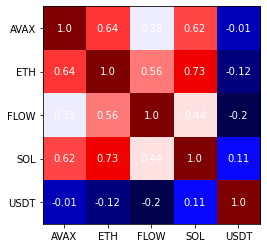

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1)
im = ax.imshow(return_corr, cmap="seismic")
ax.set_xticks(np.arange(len(return_corr.columns)), labels=return_corr.columns)
ax.set_yticks(np.arange(len(return_corr.index)), labels=return_corr.index)
for i in range(len(return_corr.index)):
    for j in range(len(return_corr.columns)):
        text = ax.text(j, i, round(return_corr.iloc[i, j],2), ha="center", va="center", color="w")
plt.show()